In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from glob import glob
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import math
import cv2
%matplotlib inline

#data_dir = os.path.join(os.getcwd(), 'data', 'whale')
#full_img_dir = os.path.join(os.getcwd(), 'data', 'whale', 'imgs')
cwd = os.getcwd()
rot_dir = os.path.join(os.getcwd(), 'rot')
img_dir  = os.path.join(os.getcwd(), 'imgs_subset')
#resize_dir = os.path.join(os.getcwd(), 'data', 'whale', 'resized')
#crop_dir = os.path.join(data_dir, 'crops')
img_shape=(3, 224, 224)
target_size = (224,224)

Using Theano backend.


In [ ]:
points1 = pd.read_json(data_dir +'/points1.json')

In [6]:
points1.head()

,annotations,class,filename
0,"[{u'y': 864.388663968, u'x': 1361.87854251, u'...",image,w_1.jpg
1,"[{u'y': 573.431704885, u'x': 1242.16151545, u'...",image,w_100.jpg
2,"[{u'y': 908.634097707, u'x': 1633.4995015, u'c...",image,w_1000.jpg
3,"[{u'y': 784.079760718, u'x': 2431.87238285, u'...",image,w_1003.jpg
4,"[{u'y': 1567.77666999, u'x': 3972.84945165, u'...",image,w_1004.jpg


In [7]:
points2 = pd.read_json(data_dir +'/points2.json')

In [8]:
def getProp(x, prop):
    return x[0][prop]

In [9]:
points1['x'] = points1.annotations.apply(lambda v: getProp(v, 'x'))
points1['y'] = points1.annotations.apply(lambda v: getProp(v, 'y'))
points2['x'] = points2.annotations.apply(lambda v: getProp(v, 'x'))
points2['y'] = points2.annotations.apply(lambda v: getProp(v, 'y'))

In [10]:
points1.head()

,annotations,class,filename,x,y
0,"[{u'y': 864.388663968, u'x': 1361.87854251, u'...",image,w_1.jpg,1361.878543,864.388664
1,"[{u'y': 573.431704885, u'x': 1242.16151545, u'...",image,w_100.jpg,1242.161515,573.431705
2,"[{u'y': 908.634097707, u'x': 1633.4995015, u'c...",image,w_1000.jpg,1633.499501,908.634098
3,"[{u'y': 784.079760718, u'x': 2431.87238285, u'...",image,w_1003.jpg,2431.872383,784.079761
4,"[{u'y': 1567.77666999, u'x': 3972.84945165, u'...",image,w_1004.jpg,3972.849452,1567.776670


In [11]:
points2.head()

,annotations,class,filename,x,y
0,"[{u'y': 903.773279352, u'x': 1573.31174089, u'...",image,w_1.jpg,1573.311741,903.773279
1,"[{u'y': 384.478564307, u'x': 1289.8105683, u'c...",image,w_100.jpg,1289.810568,384.478564
2,"[{u'y': 1057.69092722, u'x': 1615.1226321, u'c...",image,w_1000.jpg,1615.122632,1057.690927
3,"[{u'y': 939.26221336, u'x': 2209.30807577, u'c...",image,w_1003.jpg,2209.308076,939.262213
4,"[{u'y': 1550.54835494, u'x': 3583.48953141, u'...",image,w_1004.jpg,3583.489531,1550.548355


In [12]:
points1.to_csv('points1.csv', index=False)
points2.to_csv('points2.csv', index=False)

In [13]:
points1 = pd.read_csv('points1.csv')
points2 = pd.read_csv('points2.csv')

In [8]:
tr = pd.read_csv('train.csv')

In [9]:
tr[tr.Image == 'w_1.jpg']

,Image,whaleID
2230,w_1.jpg,whale_72820


In [31]:
ann = pd.read_csv(data_dir + '/ann_adj_360_240.csv')

In [17]:
targ = ann[ann.Image == 'w_1.jpg']

In [32]:
ann.columns

Index([u'Unnamed: 0', u'Image', u'whaleID', u'Unnamed: 0.1', u'annotations',
       u'class', u'filename', u'jpg', u'height', u'width', u'x', u'y',
       u'act_width', u'act_height', u'ratio_act_smaller', u'adj_height',
       u'adj_width', u'adj_x', u'adj_y', u'ratio_width', u'ratio_height'],
      dtype='object')

In [33]:
ann = ann[['Image', 'whaleID', 'height', 'width', 'act_width', 'act_height', 'x', 'y']]

In [34]:
ann.head()

,Image,whaleID,height,width,act_width,act_height,x,y
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460


In [35]:
ann = ann.rename(columns={'act_width': 'image_width', 'act_height': 'image_height', 'x': 'bboxx', 'y': 'bboxy'})

In [36]:
ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460


In [37]:
points1 = points1[['filename', 'x', 'y']]

In [38]:
points2 = points2[['filename', 'x', 'y']]

In [39]:
ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460


In [42]:
points = points1.merge(points2, on='filename', suffixes=('_1', '_2'))

In [44]:
points.head()

,filename,x_1,y_1,x_2,y_2
0,w_1.jpg,1361.878543,864.388664,1573.311741,903.773279
1,w_100.jpg,1242.161515,573.431705,1289.810568,384.478564
2,w_1000.jpg,1633.499501,908.634098,1615.122632,1057.690927
3,w_1003.jpg,2431.872383,784.079761,2209.308076,939.262213
4,w_1004.jpg,3972.849452,1567.776670,3583.489531,1550.548355


In [45]:
ann = ann.merge(points, left_on='Image', right_on='filename')

In [169]:
ann.tail()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2
4539,w_9399.jpg,whale_09651,482.154012,476.547570,2464,1648,868.998510,504.579780,w_9399.jpg,1112.358923,584.933200,1031.848455,777.172483
4540,w_9403.jpg,whale_06967,219.548629,318.699623,3072,2048,2377.263116,1411.721294,w_9403.jpg,2623.808574,1494.652044,2437.998006,1480.358923
4541,w_9428.jpg,whale_55333,395.254161,399.206703,3072,2048,1494.060729,1288.528565,w_9428.jpg,1602.871386,1562.033898,1717.216351,1433.395813
4542,w_9450.jpg,whale_24458,469.338312,529.253841,3072,2048,279.605803,129.816980,w_9450.jpg,481.882353,218.480558,684.027916,441.044865
4543,w_9468.jpg,whale_66205,489.310155,535.911122,3072,2048,1388.043093,812.188284,w_9468.jpg,1739.676969,888.215354,1643.708873,1025.020937


# Rotate

In [14]:
% cd $img_dir

/home/ryanryanadmin/Documents/ds/whale_recognition/imgs_subset


In [15]:
g = glob('*.jpg')

In [16]:
g[:5]

['w_281.jpg', 'w_224.jpg', 'w_116.jpg', 'w_99.jpg', 'w_0.jpg']

In [5]:
ann = pd.read_csv(os.path.join(cwd, 'bonnet_and_bbox.csv'))

In [6]:
ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591,w_7812.jpg,1668.211366,1370.097707,1647.792622,1108.737787
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,1212.873380,1353.762712,1265.962114
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429,w_3828.jpg,1118.947159,908.634098,1345.595214,963.764706
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,1223.082752,1682.504487,1069.942173
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,1071.984048,1662.085743,878.005982


In [26]:
def crop_and_align(r, target_width, target_height, input_dir, save_dir):
    #print(r)
    path = os.path.join(input_dir, r.Image)
    print(path)
    im = cv2.imread(path)
    
    y_start = int(r.bboxy)
    x_start = int(r.bboxx)
    y_crop = int(r.bboxy + r.height)
    x_crop = int(r.bboxx + r.width) 

    cropped = im[y_start:y_crop, x_start:x_crop]
    
    x1_crop = r.x_1 - x_start
    x2_crop = r.x_2 - x_start
    x1_final = (target_width / r.width) * x1_crop
    x2_final = (target_width / r.width) * x2_crop


    y1_crop = r.y_1 - y_start
    y2_crop = r.y_2 - y_start
    y1_final = (target_height / r.height) * y1_crop
    y2_final = (target_height / r.height) * y2_crop
    
    ang = bearing(x1_crop, y1_crop, x2_crop, y2_crop)
    image_height, image_width = cropped.shape[0:2]
    rot = rotate_image(cropped, ang)
    w, h = largest_rotated_rect(image_width, image_height, math.radians(ang))
    rot_n = crop_around_center(rot,w,h,  (y1_final, x1_final ), ( y2_final, x2_final))
    #cv2.imwrite(os.path.join(save_dir, r.Image), rot_n)
    plt.imshow(rot_n)
    plt.show()

/home/ryanryanadmin/Documents/ds/whale_recognition/imgs_subset/w_99.jpg


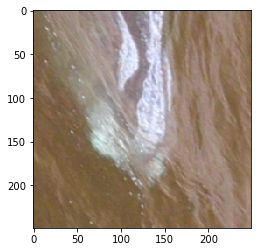

/home/ryanryanadmin/Documents/ds/whale_recognition/imgs_subset/w_116.jpg


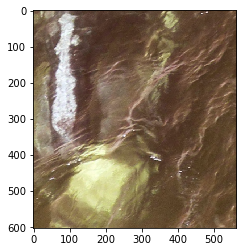

/home/ryanryanadmin/Documents/ds/whale_recognition/imgs_subset/w_281.jpg


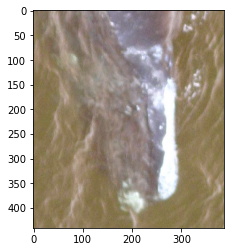

In [27]:
target_width = 300
target_height = 268

for row in ann.iterrows():
    #print(row[1].Image)
    if row[1].Image not in g[:5]: continue
    #if row[1].Image not in g: continue
    #print('through')
    data = row[1]
    crop_and_align(data, target_width, target_height, img_dir, rot_dir)
    #print(row[1].height)

/home/ryanryanadmin/Documents/ds/whale_recognition/imgs_subset/w_99.jpg
(74, 100)


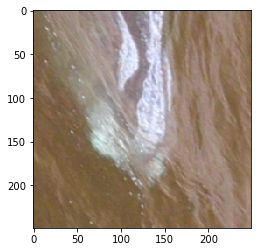

/home/ryanryanadmin/Documents/ds/whale_recognition/imgs_subset/w_116.jpg
(72, 120)


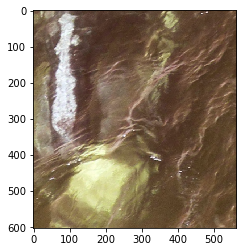

/home/ryanryanadmin/Documents/ds/whale_recognition/imgs_subset/w_281.jpg
(97, 148)


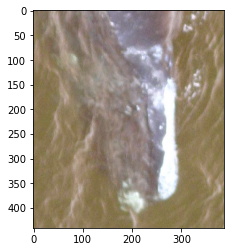

In [29]:
target_width = 300
target_height = 268

for row in ann.iterrows():
    #print(row[1].Image)
    if row[1].Image not in g[:5]: continue
    #if row[1].Image not in g: continue
    #print('through')
    data = row[1]
    crop_and_align(data, target_width, target_height, img_dir, rot_dir)
    #print(row[1].height)

In [21]:
def bearing(a1, a2,  b1,  b2):
    TWOPI = 6.2831853071795865;
    RAD2DEG = 57.2957795130823209;
    
    theta = math.atan2(b1 - a1, a2 - b2);
    if theta < 0.0:
        theta += TWOPI;
    return RAD2DEG * theta;


In [28]:
def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height, pt1, pt2):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """
    image_size = (image.shape[1], image.shape[0])
    
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))
    image_center_2 = (int((pt1[0] + pt2[0]) * 0.5), int((pt1[1] + pt2[1]) * 0.5))
    
    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]
    
    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

In [63]:
def crop_and_align_copy(r, target_width, target_height):
    #print(r)
    if r.Image != 'w_116.jpg': return
    path = os.path.join(img_dir, r.Image)
    print(path)
    im = cv2.imread(path)
    
    y_start = int(r.bboxy)
    x_start = int(r.bboxx)
    y_crop = int(r.bboxy + r.height)
    x_crop = int(r.bboxx + r.width) 

    cropped = im[y_start:y_crop, x_start:x_crop]
    
    x1_crop = r.x_1 - x_start
    x2_crop = r.x_2 - x_start
    x1_final = (target_width / r.width) * x1_crop
    x2_final = (target_width / r.width) * x2_crop


    y1_crop = r.y_1 - y_start
    y2_crop = r.y_2 - y_start
    y1_final = (target_height / r.height) * y1_crop
    y2_final = (target_height / r.height) * y2_crop
    
    ang = bearing(x1_crop, y1_crop, x2_crop, y2_crop)
    image_height, image_width = cropped.shape[0:2]
    rot = rotate_image(cropped, ang)
    w, h = largest_rotated_rect(image_width, image_height, math.radians(ang))
    rot_n = crop_around_center(rot,w,h, (x1_final, y1_final), (x2_final, y2_final))
    
    
    
    #ar1 = patches.Arrow(x1_crop, y1_crop, 10, 10, width=2.0, color='red')
    #ar2 = patches.Arrow(x2_crop, y2_crop, 10, 10, width=2.0, color='yellow')
    #fig,ax = plt.subplots(1)

    # Display the image
    #ax.imshow(rot_n)
    #ax.add_patch(ar1)
    #ax.add_patch(ar2)

     # Create a Rectangle patch
    #plt.show()
    
    
    #plt.imshow(rot_n)
    #plt.show()

    #return im
    #image_height, image_width = image.shape[0:2]

# Test

In [20]:

% cd $rot_dir

/home/ryanryanadmin/Documents/ds/whale_recognition/rot


In [21]:
g = glob('*.jpg')

In [23]:
g = np.random.permutation(g)

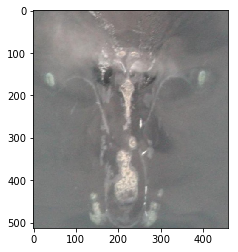

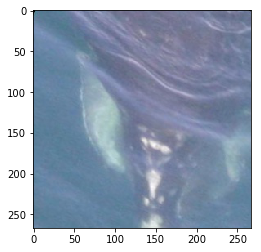

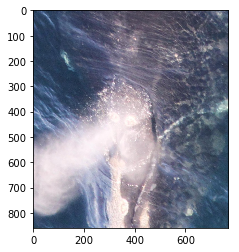

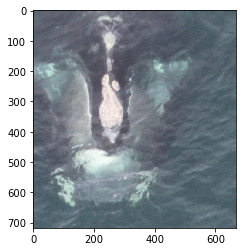

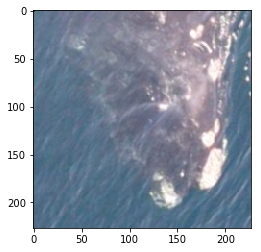

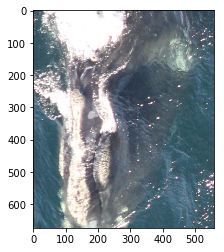

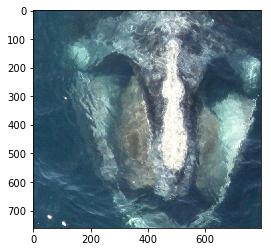

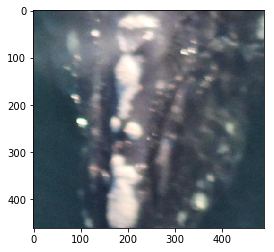

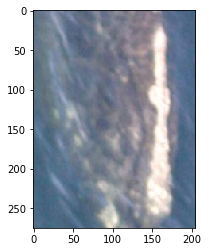

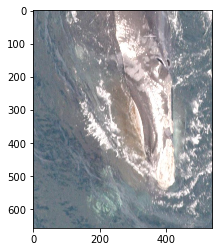

In [24]:
for f in g[:10]:
    im = Image.open(os.path.join(rot_dir, f))
    plt.imshow(im)
    plt.show()